# Compare sPlotOpen and GBIF trait maps (TRY gap-filled)

We will create trait maps with the GBIF observation data and evaluate the maps using the sPlotOpen data.

This section covers:

- Load Data
- Visualizing the trait maps - a first look
- Grid mean trait values at different resolutions
- Calculate weighted r
- Determine slope of correlation
- Plot correlation plots at 2 degree resolution

In [1]:
# packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm
import geopandas as gpd

from pyproj import Proj # allows for different projections 
from shapely.geometry import shape # for calculating areas

## Load Data

In [2]:
GBIF_TRY = pd.read_csv("/net/scratch/swolf/GBIF/gbif_sample_all_cells_hex9.csv")

In [6]:
GBIF_TRY.columns

Index(['hex9', 'speciesName', 'gbifID', 'speciesKey', 'scientificName',
       'decimalLatitude', 'decimalLongitude', 'datasetKey', 'eventDate',
       'hex6', 'hex7', 'hex8', 'hex10', 'Species', 'X1080', 'X11', 'X13',
       'X138', 'X14', 'X144', 'X145', 'X146', 'X15', 'X163', 'X169', 'X18',
       'X21', 'X223', 'X224', 'X237', 'X26', 'X27', 'X281', 'X282', 'X289',
       'X3112', 'X3113', 'X3114', 'X3120', 'X4', 'X46', 'X47', 'X50', 'X55',
       'X6', 'X78', 'X95'],
      dtype='object')

In [8]:
# Ln-transform trait values
columns_to_transform = GBIF_TRY.columns[14:]  # Select columns
columns_to_transform = columns_to_transform.drop(['X4', 'X47', 'X78', 'X95'])

GBIF_TRY[columns_to_transform] = GBIF_TRY[columns_to_transform].apply(np.log)

In [51]:
def gridmap(long, lat, label, projection, colorbar=True):
    
    plt.rcParams.update({'font.size': 15})

    Z, xedges, yedges = np.histogram2d(np.array(long,dtype=float),
                                   np.array(lat),bins = [181, 91])

    #https://stackoverflow.com/questions/67801227/color-a-2d-histogram-not-by-density-but-by-the-mean-of-a-third-column
    #https://medium.com/analytics-vidhya/custom-strava-heatmap-231267dcd084
    
    #let function know what projection provided data is in:
    data_crs = ccrs.PlateCarree()
    
    #for colorbar
    cmap = plt.get_cmap('cool')
    im_ratio = Z.shape[0]/Z.shape[1]

    #plot map
    #create base plot of a world map
    ax = fig.add_subplot(1, 1, 1, projection=projection) # I used the PlateCarree projection from cartopy
    
    # set figure to map global extent (-180,180,-90,90)
    ax.set_global()
    
    #ax.add_feature(cfeature.OCEAN, zorder=100, edgecolor='w', facecolor = 'lightgoldenrodyellow', linewidth=1)
    #add coastlines
    ax.coastlines(resolution='110m', color='midnightblue', linewidth=1.3)
    
    #ax.add_feature(cfeature.OCEAN, zorder=100, edgecolor='w', facecolor = 'lavender', linewidth=0.8)
    
    #add grid with values
    im = ax.pcolormesh(xedges, yedges, Z.T, cmap="plasma_r", norm=LogNorm(), transform=data_crs)
    
    #add color bar
    if colorbar==True:
        fig.colorbar(im,fraction=0.046*im_ratio, pad=0.04, shrink=0.3, location="left", label=label)



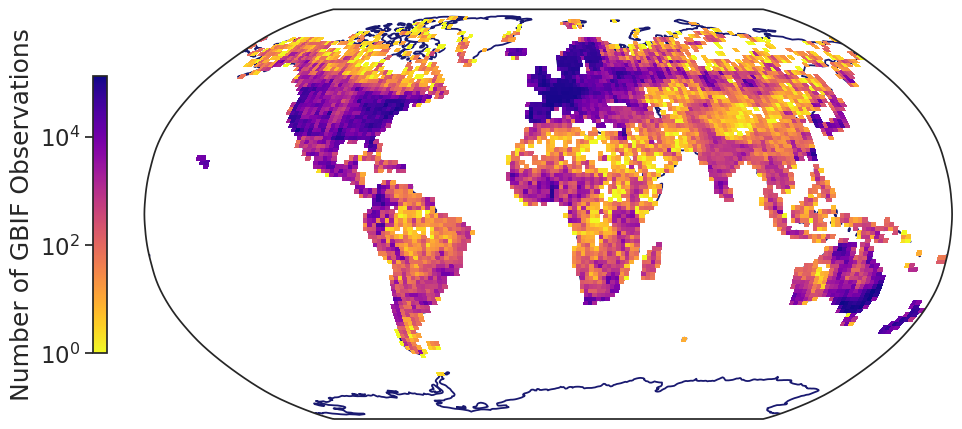

In [52]:
fig = plt.figure(figsize=(12, 12))
gridmap(GBIF_TRY['decimalLongitude'], GBIF_TRY['decimalLatitude'], "Number of GBIF Observations", ccrs.Robinson())
#plt.savefig('../Figures/green_alt_iNat_density_Robinson_all.pdf', bbox_inches='tight')

In [9]:
GBIF_TRY.head()

hex9            speciesName      gbifID  speciesKey  \
0  40305         Ifloga spicata  3039376732     3103501   
1  40305    Launaea arborescens  2992676952     3144854   
2  40305        Peganum harmala  3058882751     3189912   
3  40305  Aaronsohnia pubescens  3923585370     3092964   
4  40305         Reseda villosa  3044690784     3916548   

                                      scientificName  decimalLatitude  \
0                  Ifloga spicata (Forssk.) Sch.Bip.        31.853535   
1                  Launaea arborescens (Batt.) Murb.        31.855353   
2                                 Peganum harmala L.        31.852603   
3  Aaronsohnia pubescens (Desf.) K.Bremer & Humph...        31.853469   
4                               Reseda villosa Coss.        31.852554   

   decimalLongitude                            datasetKey  \
0         -4.954888  50c9509d-22c7-4a22-a47d-8c48425ef4a7   
1         -4.945700  50c9509d-22c7-4a22-a47d-8c48425ef4a7   
2         -4.956154  50c9509d-22c7-4a22-a47d-8c48425ef4a7   
3         -4.946656  50c9509d-22c7-4a22-a47d-8c48425ef4a7   
4         -4.948295  50c9509d-22c7-4a22-a47d-8c48425ef4a7   

              eventDate  hex6  ...     X3114     X3120        X4       X46  \
0  2015-03-26T00:00:00Z  1502  ...  5.835266  1.312058  0.516030 -1.090813   
1  2015-03-26T00:00:00Z  1502  ...  6.621530  1.303937  0.474641 -0.844836   
2  2015-03-26T00:00:00Z  1502  ...  4.487740  1.290178  0.449180 -0.905946   
3  2015-03-26T00:00:00Z  1502  ...  5.971502  1.624601  0.486141 -1.274997   
4  2015-03-26T00:00:00Z  1502  ...  5.874709  1.786333  0.623317 -1.370391   

        X47       X50       X55        X6       X78        X95  
0  0.307016  0.183187  3.408664 -0.230779 -1.463916  91.478674  
1  0.306539  0.683602  4.167893 -0.237374  0.811000  82.308425  
2  0.336047  0.750923  2.327651 -0.956023  5.613837  88.495846  
3  0.228487  0.275202  3.242681 -0.511613  0.127767  90.961137  
4  0.174054  0.674683  2.825824 -0.715483  5.616796  88.732339  

[5 rows x 47 columns]

In [10]:
sPlot = pd.read_csv("/net/home/swolf/iNaturalist/Data/sPlotOpen/sPlotOpen_TRYgapfilled_cwm.csv")

In [11]:
sPlot.head(2)

PlotObservationID     X1080       X11       X13      X138       X14  \
0                 16  8.579904  2.586882  6.130671  5.119874  2.824851   
1                 17  8.579904  2.586882  6.130671  5.119874  2.824851   

       X144     X145      X146       X15  ...       X46      X47       X50  \
0  3.773571 -1.95713  3.303937  1.104837  ... -1.512323  0.34299  0.221844   
1  3.773571 -1.95713  3.303937  1.104837  ... -1.512323  0.34299  0.221844   

        X55        X6       X78        X95  Releve_area  Latitude  Longitude  
0  1.362826 -1.589643 -2.160506  94.683061          NaN     62.42    -154.18  
1  1.362826 -1.589643 -2.160506  94.683061          NaN     62.42    -154.18  

[2 rows x 37 columns]

## Visualize trait maps

In [12]:
def plot_grid(df, lon, lat, variable, dataset_name, deg, log=True):

    plt.rcParams.update({'font.size': 15})

    # define raster shape for plotting
    step = int((360/deg) + 1)
    bins_x = np.linspace(-180,180,step) 
    bins_y= np.linspace(-90,90,int(((step - 1)/2)+1))


    df['x_bin'] = pd.cut(df[lon], bins=bins_x)
    df['y_bin'] = pd.cut(df[lat], bins=bins_y)

    df['x_bin'] = df['x_bin'].apply(lambda x: x.left)
    df['y_bin'] = df['y_bin'].apply(lambda x: x.left)

    grouped_df = df.groupby(['x_bin', 'y_bin'], as_index=False)[variable].mean()
    raster = grouped_df.pivot('y_bin', 'x_bin', variable)

    # data format
    data_crs = ccrs.PlateCarree()
    
    #for colorbar
    levels = MaxNLocator(nbins=15).tick_values(grouped_df[variable].min(), grouped_df[variable].max())
    cmap = plt.get_cmap('YlGnBu') # colormap
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True) 
    im_ratio = raster.shape[0]/raster.shape[1] # for size of colorbar

    #create base plot of a world map
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson()) # I used the PlateCarree projection from cartopy
    ax.set_global()
        
    #add grid with values
    im = ax.pcolormesh(bins_x, bins_y, raster, cmap="YlGnBu", 
                       vmin=grouped_df[t].min(),
                       vmax=grouped_df[t].max(),
                       transform=data_crs) 
    
    #add color bar
    if log==True:
            label= "ln " + str(t)
    else:
        label= str(t)
    
    fig.colorbar(im,fraction=0.046*im_ratio, pad=0.04, label=label, orientation="horizontal")

    #add coastlines
    #ax.add_feature(cfeature.OCEAN, zorder=100, edgecolor='w', facecolor = 'lavender', linewidth=0.8)
    #ax.add_feature(cfeature.OCEAN, zorder=100, facecolor = 'lightseagreen', linewidth=0.8)
    ax.coastlines(resolution='110m', color='pink', linewidth=1.5)

    #set title
    ax.set_title( variable + ' ' + dataset_name, size=14)



To visualize the trait maps we use the custom function ```plot_grid()```.

/tmp/ipykernel_182983/3317999204.py:18: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  raster = grouped_df.pivot('y_bin', 'x_bin', variable)
/tmp/ipykernel_182983/3317999204.py:18: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  raster = grouped_df.pivot('y_bin', 'x_bin', variable)
/tmp/ipykernel_182983/3317999204.py:18: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  raster = grouped_df.pivot('y_bin', 'x_bin', variable)
/tmp/ipykernel_182983/3317999204.py:18: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  raster = grouped_df.pivot('y_bin', 'x_bin', variable)
/tmp/ipykernel_182983/3317999204.py:18: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  raster = grouped_df.pivot('y_bin', 'x_bin', variable)
/tmp/ipykernel_18298

TypeError: Image data of dtype object cannot be converted to float

/net/home/swolf/.conda/envs/traitmaps/lib/python3.8/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/net/home/swolf/.conda/envs/traitmaps/lib/python3.8/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/net/home/swolf/.conda/envs/traitmaps/lib/python3.8/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


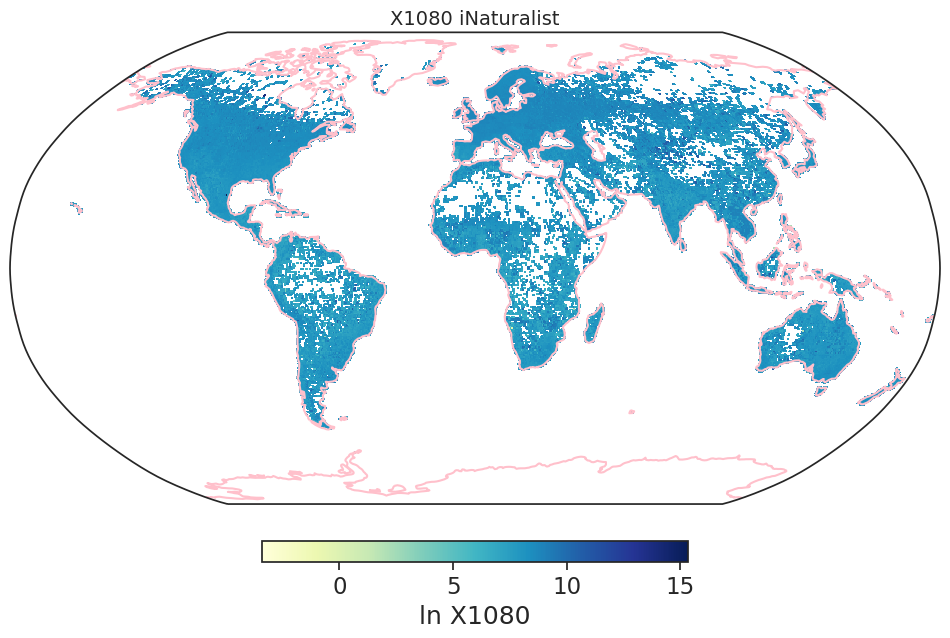

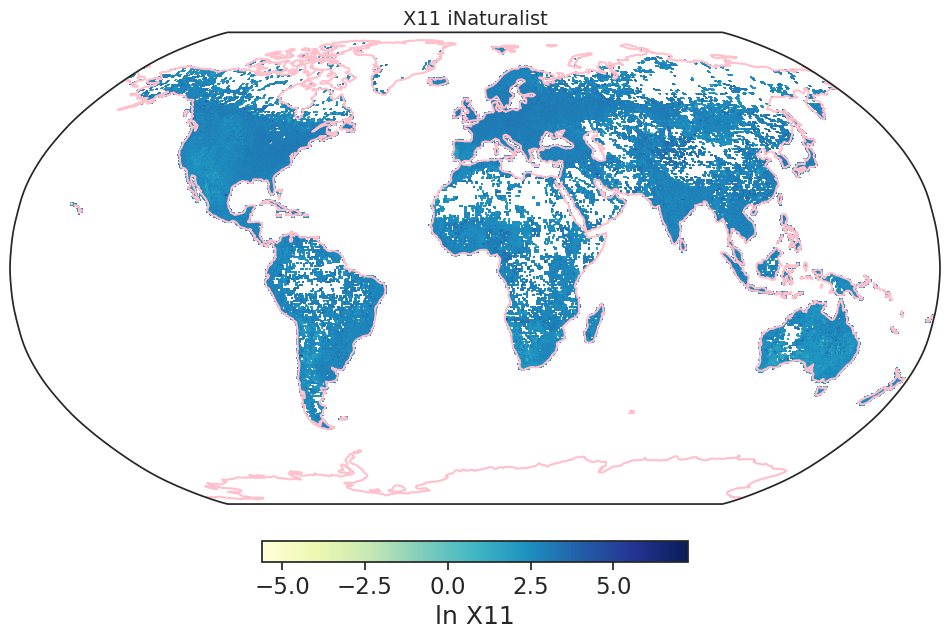

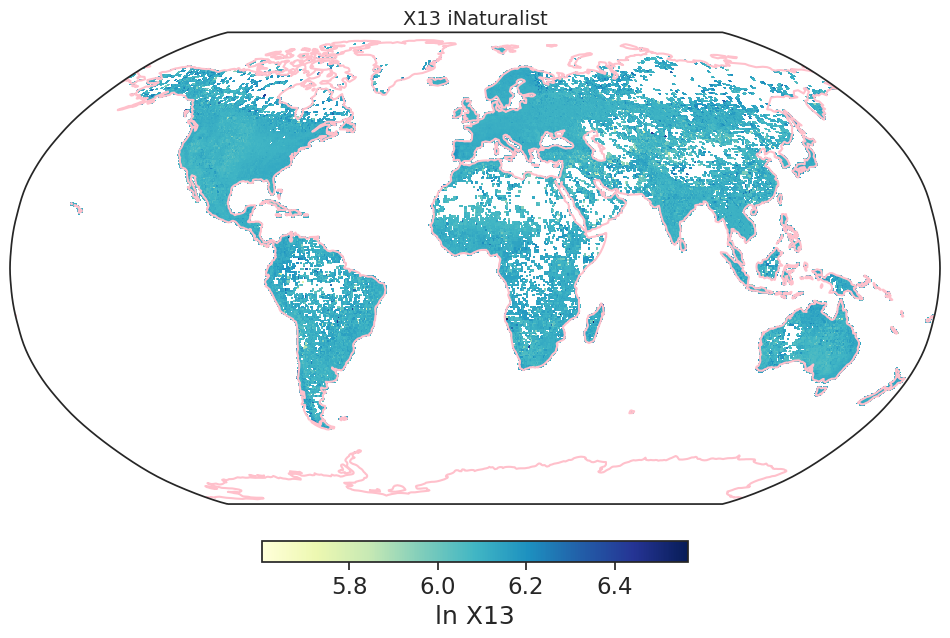

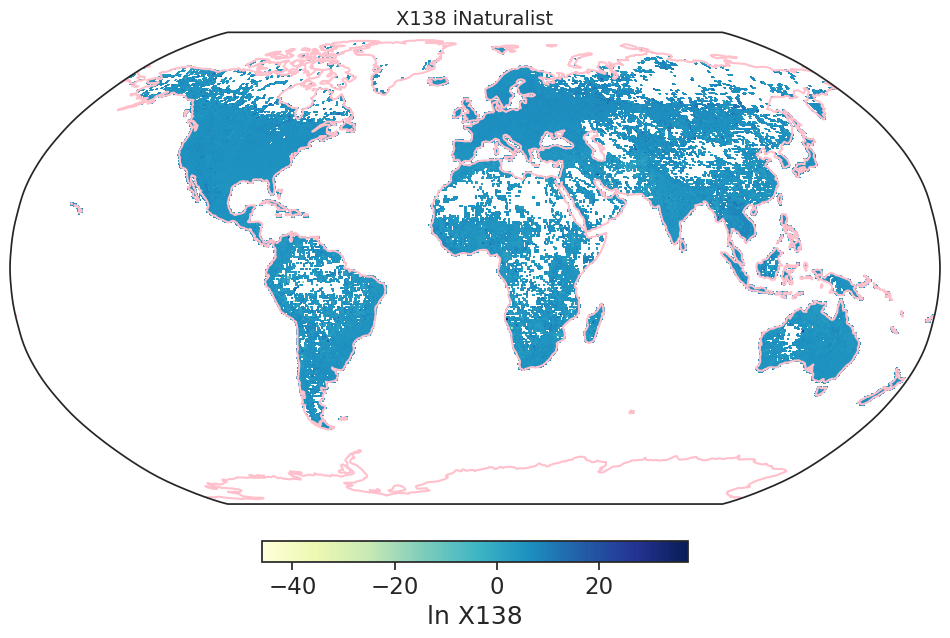

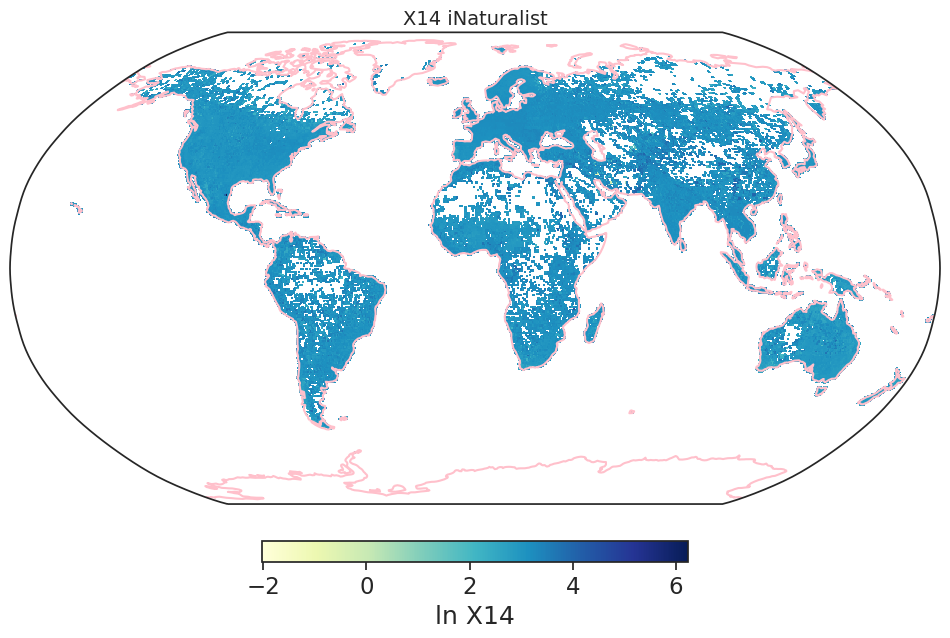

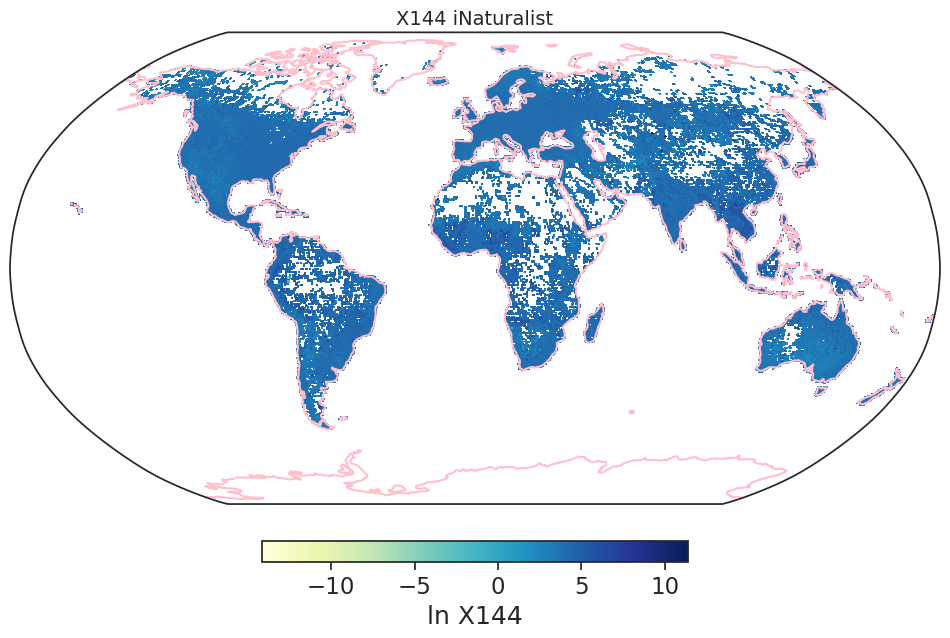

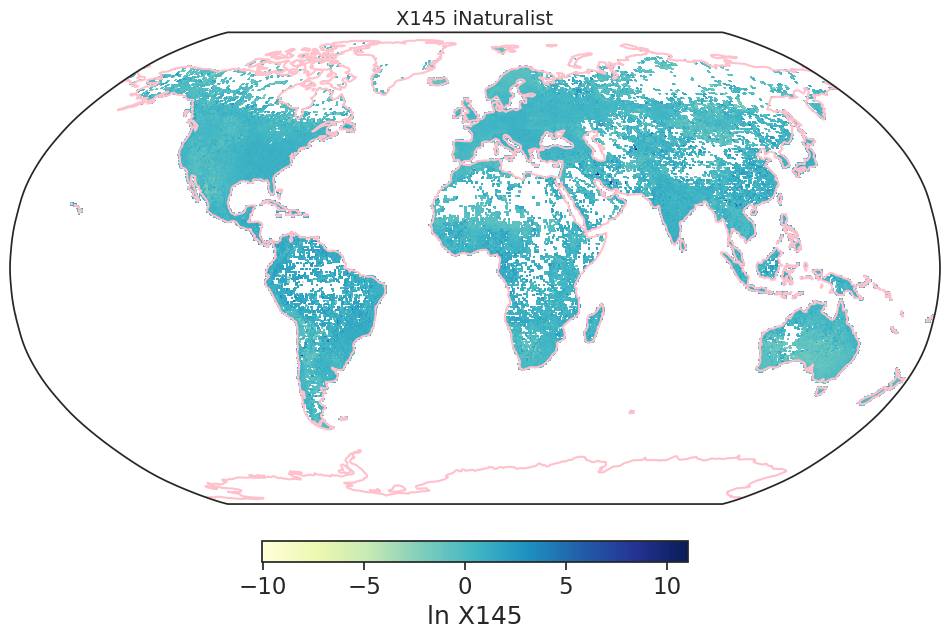

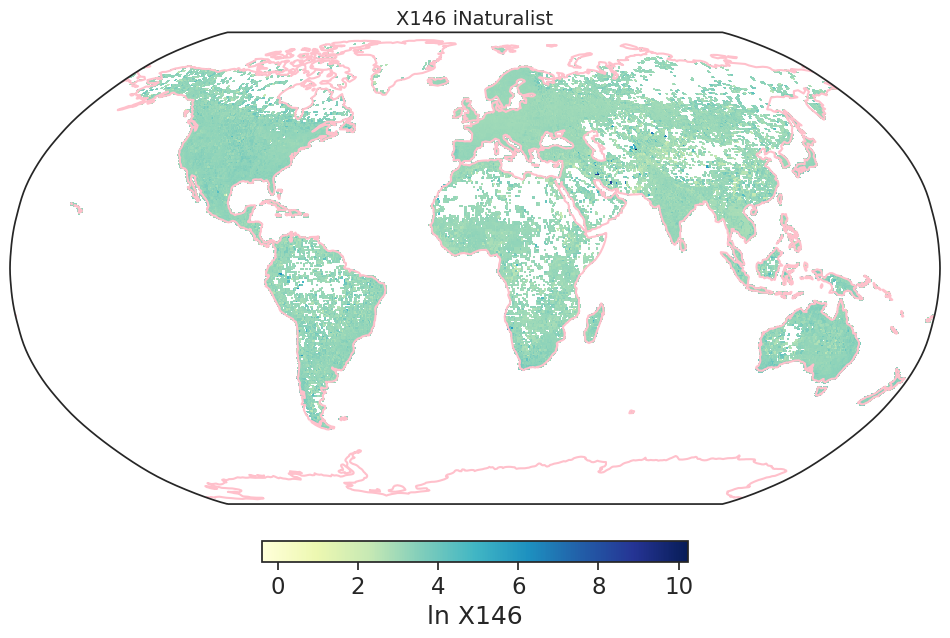

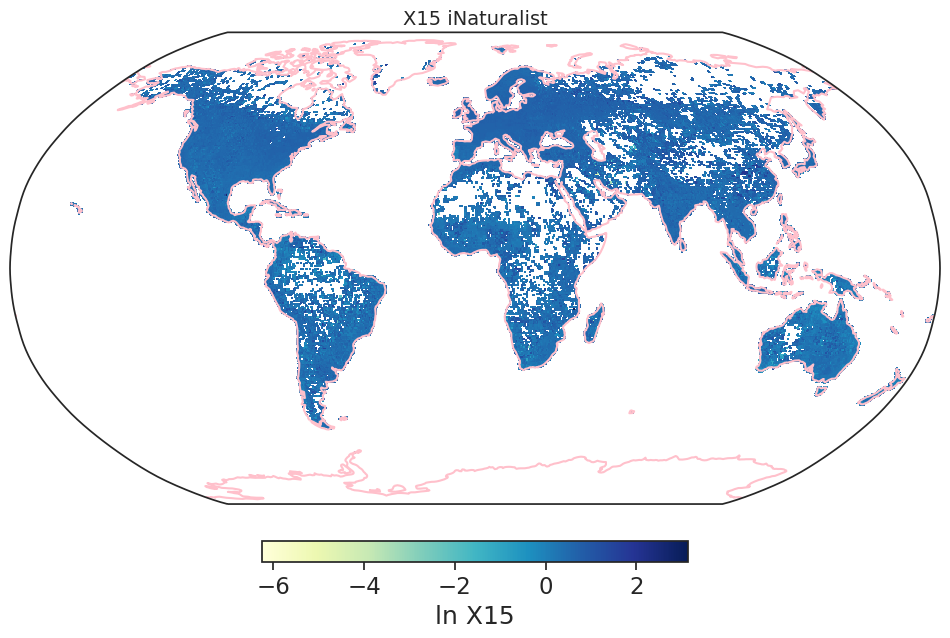

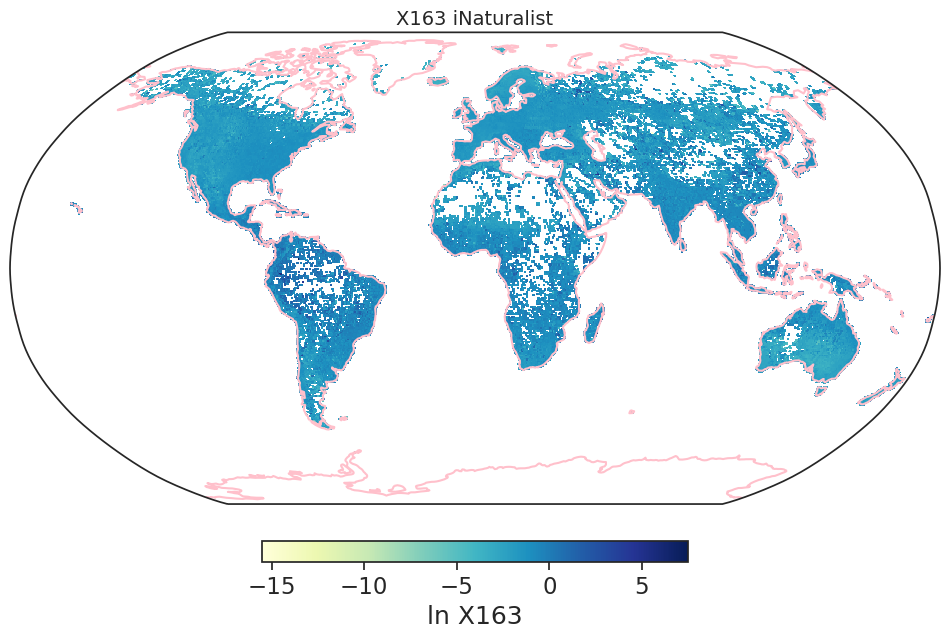

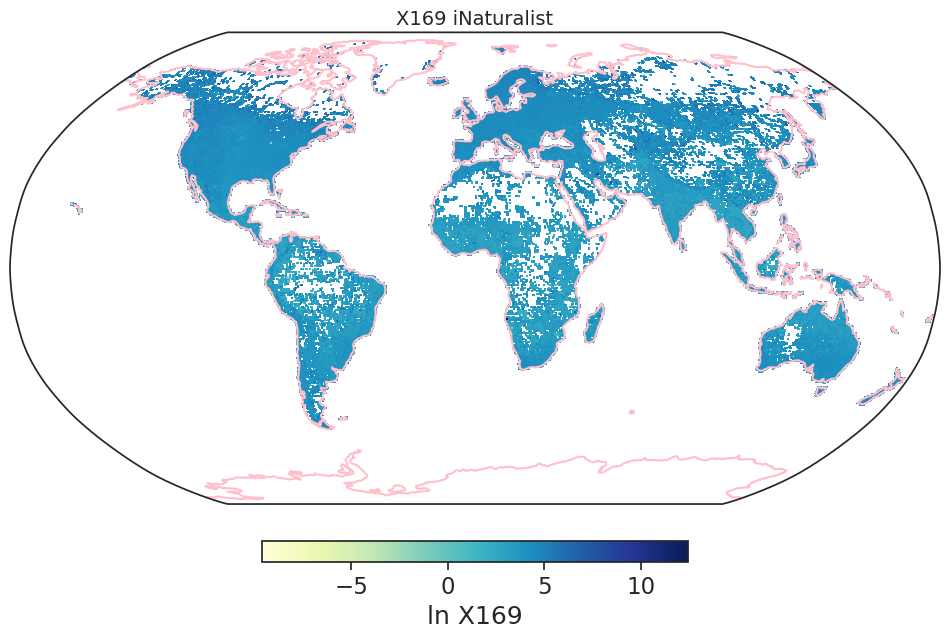

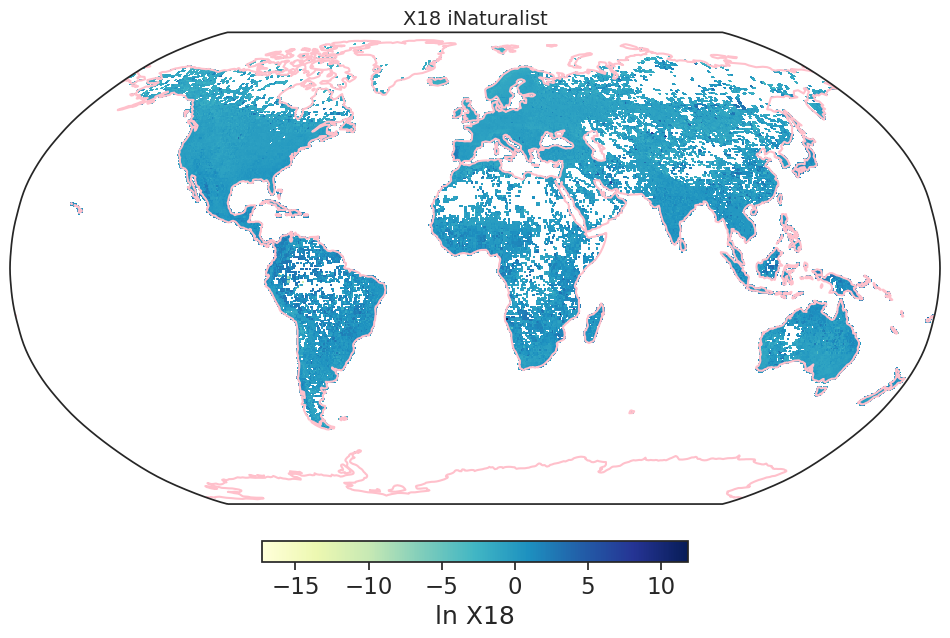

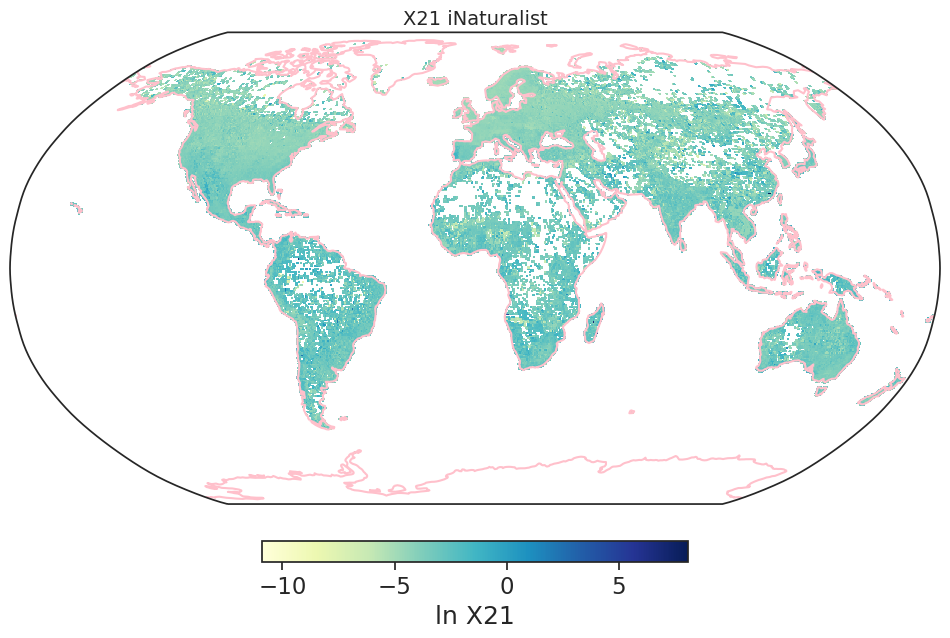

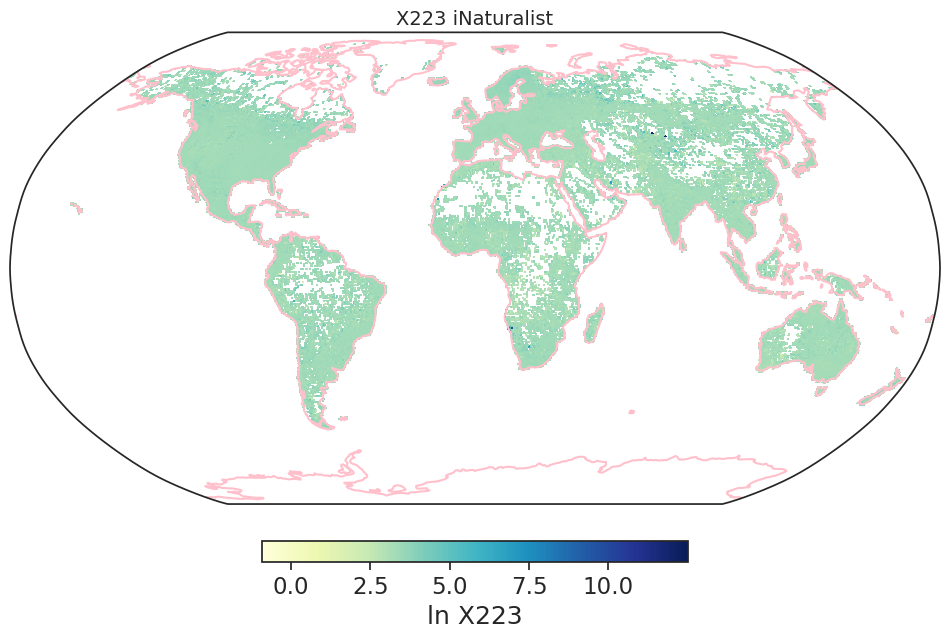

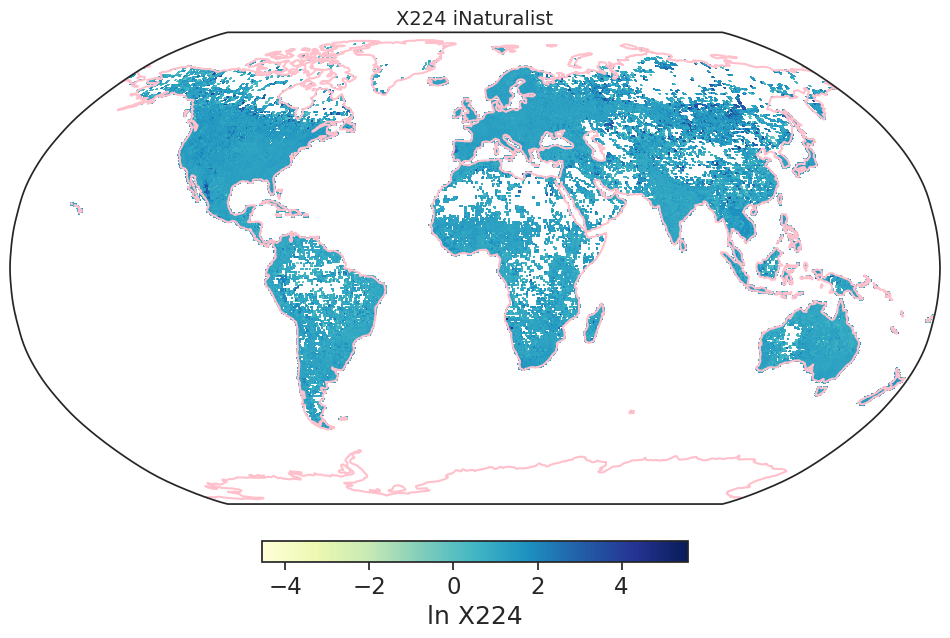

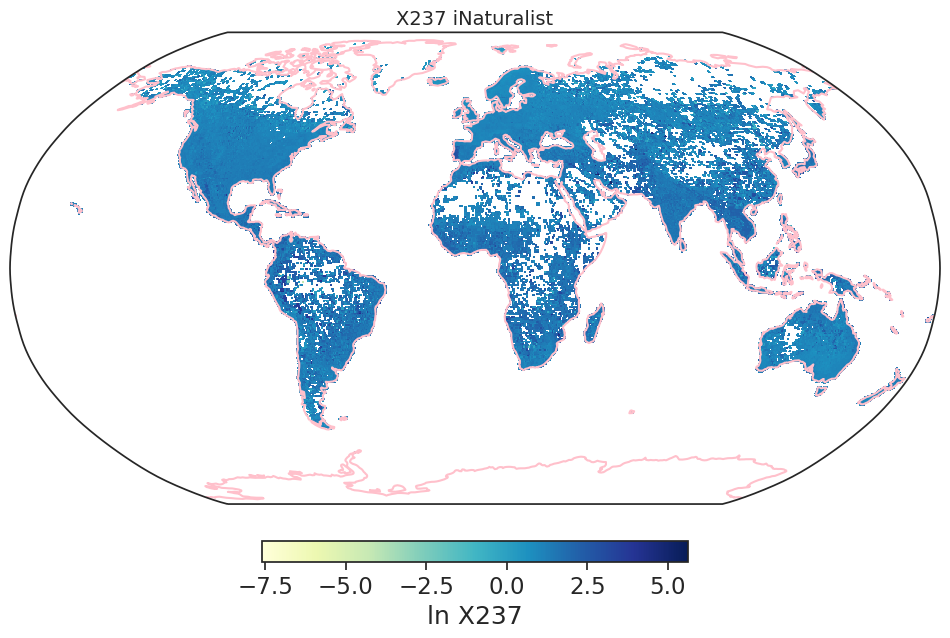

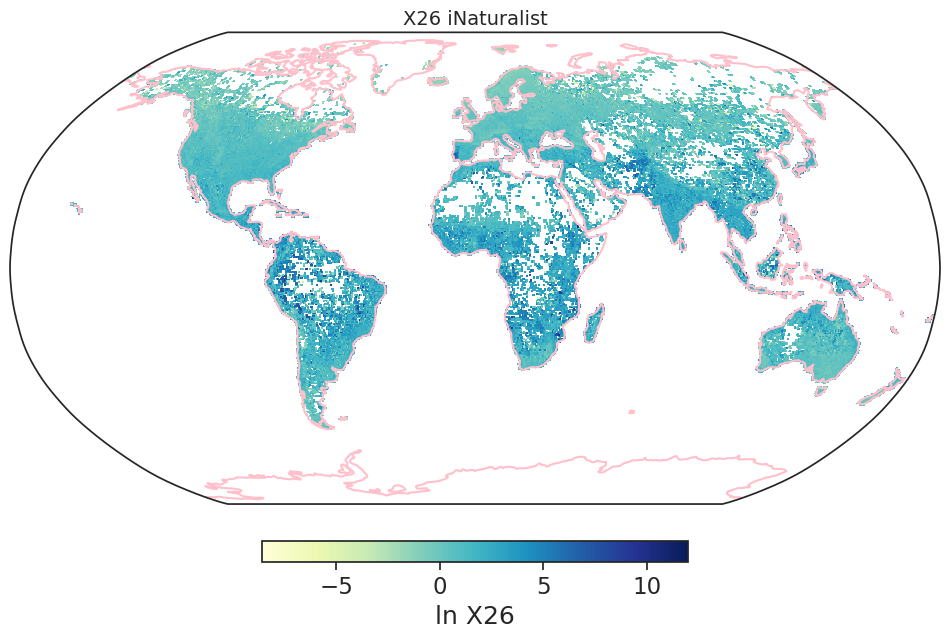

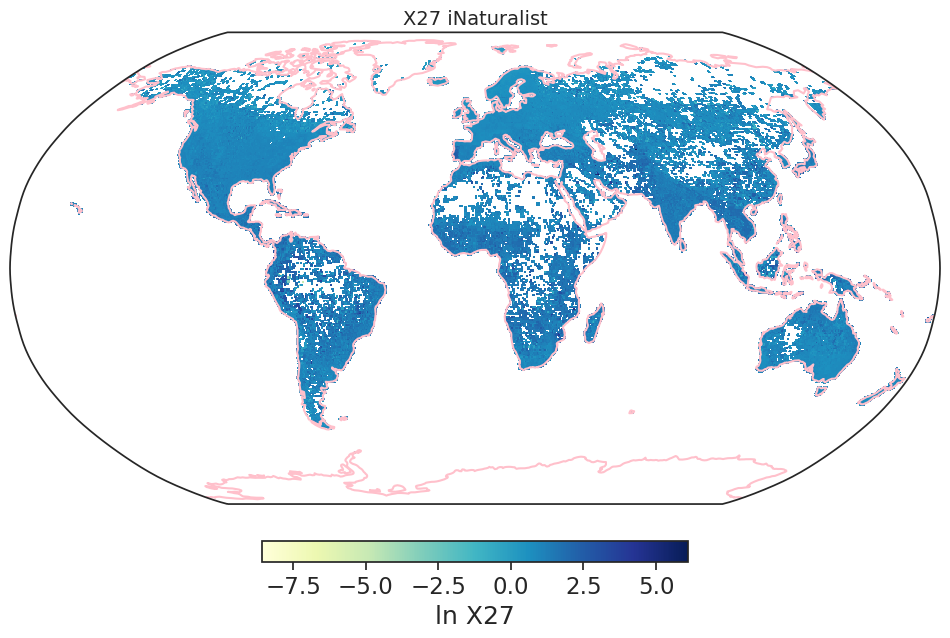

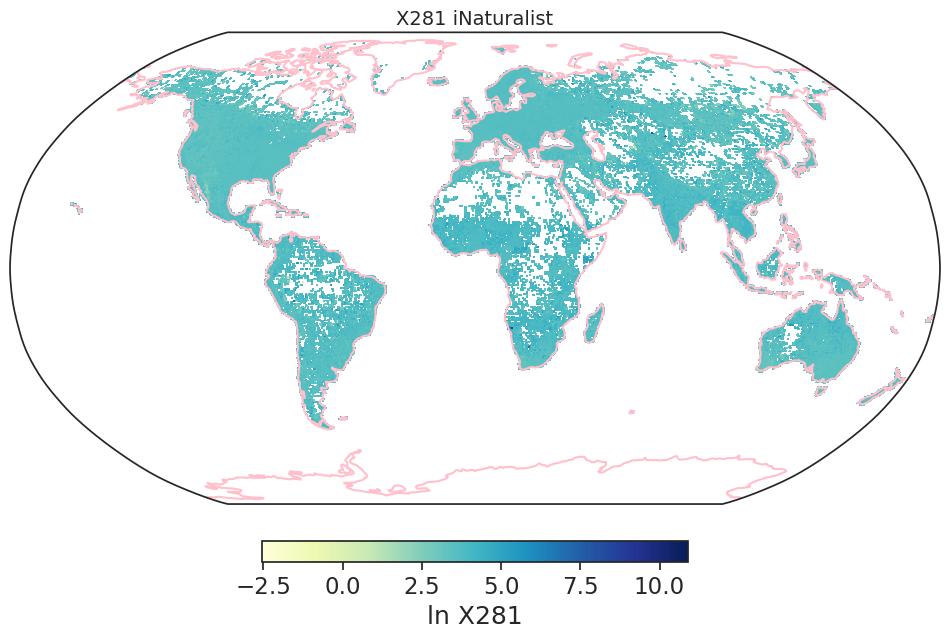

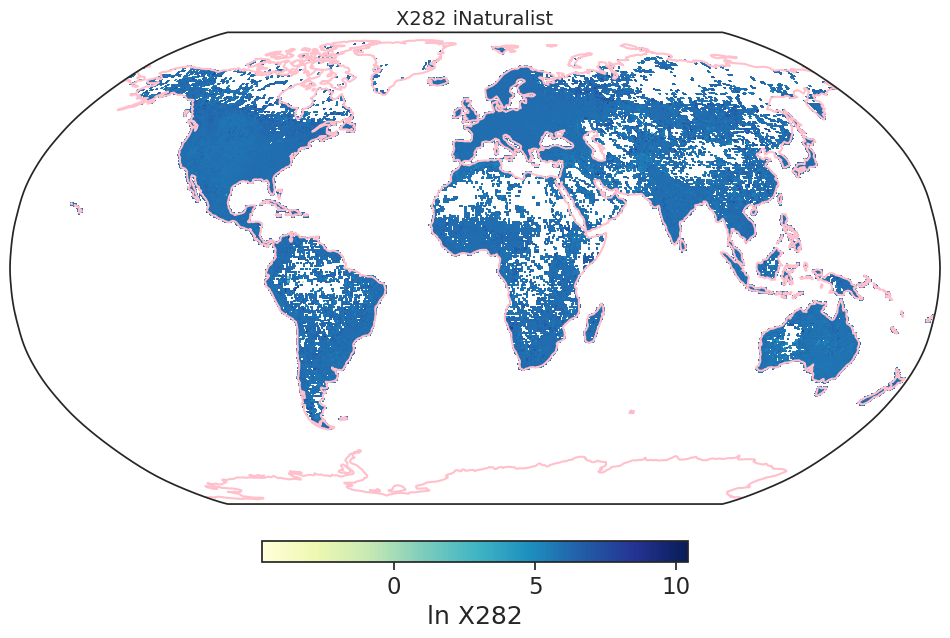

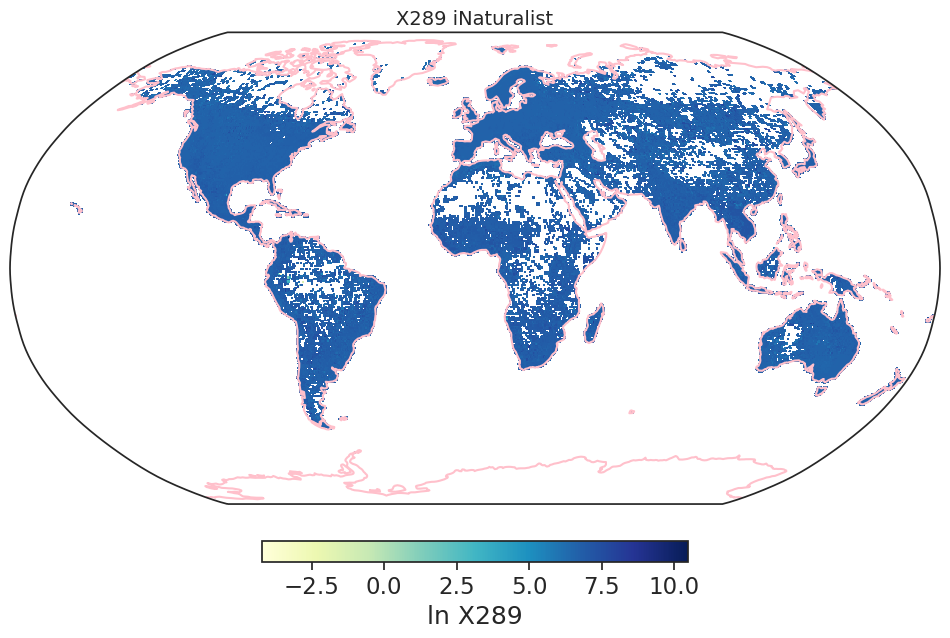

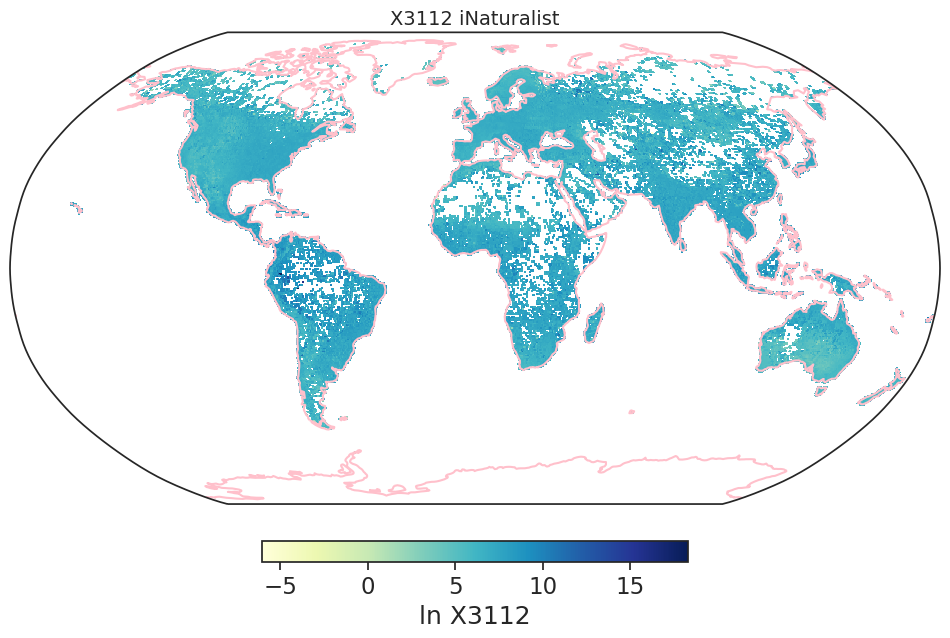

In [ ]:
trait = GBIF_TRY.columns[14:]

for t in trait:

    fig = plt.figure(figsize=(12, 12))
    filename = '../Figures/GBIF_traitmap_' + t +'.pdf'
    plot_grid(GBIF_TRY, "decimalLongitude", "decimalLatitude",variable=t, dataset_name="iNaturalist", deg=0.5)
    #plt.savefig(filename, bbox_inches='tight')

## Grid mean trait values at different resolutions

### Check function at 2 degree resolution

In [14]:
def global_grid_data(df, long, lat, deg, variables):
    
    # create new dataframe to save the average value of each grid cell and variable
    grouped_df = pd.DataFrame()
    
    # convert degree into step size
    step = int((360/deg) + 1)
    
    bins_x = np.linspace(-180,180,step) 
    bins_y= np.linspace(-90,90,int(((step - 1)/2)+1))
    
    # group latitude and longitude coordinates into bins
    # create new columns 'x_bin' and 'y_bin'
    df['x_bin'] = pd.cut(df[long], bins=bins_x)
    df['y_bin'] = pd.cut(df[lat], bins=bins_y)
    
    # raster coordinates are in center of raster cell
    df['x_bin'] = df['x_bin'].apply(lambda x: ((x.left + x.right) /2) )
    df['y_bin'] = df['y_bin'].apply(lambda x: ((x.left + x.right) /2) )
    
    grouped_df = df.drop_duplicates(subset=['x_bin', 'y_bin'], keep='last')
    grouped_df = grouped_df[['x_bin', 'y_bin']]
    
    for v in variables:
        
        sub_df = df[['y_bin', 'x_bin', v]]
        grouped_v = sub_df.groupby(['x_bin', 'y_bin'], as_index=False)[v].mean()
        
        
        grouped_df = pd.merge(grouped_df, grouped_v, 
                    on= ['x_bin', 'y_bin'], 
                    how='left')
        
    return grouped_df

In [15]:
GBIF_TRY.head()

hex9            speciesName      gbifID  speciesKey  \
0  40305         Ifloga spicata  3039376732     3103501   
1  40305    Launaea arborescens  2992676952     3144854   
2  40305        Peganum harmala  3058882751     3189912   
3  40305  Aaronsohnia pubescens  3923585370     3092964   
4  40305         Reseda villosa  3044690784     3916548   

                                      scientificName  decimalLatitude  \
0                  Ifloga spicata (Forssk.) Sch.Bip.        31.853535   
1                  Launaea arborescens (Batt.) Murb.        31.855353   
2                                 Peganum harmala L.        31.852603   
3  Aaronsohnia pubescens (Desf.) K.Bremer & Humph...        31.853469   
4                               Reseda villosa Coss.        31.852554   

   decimalLongitude                            datasetKey  \
0         -4.954888  50c9509d-22c7-4a22-a47d-8c48425ef4a7   
1         -4.945700  50c9509d-22c7-4a22-a47d-8c48425ef4a7   
2         -4.956154  50c9509d-22c7-4a22-a47d-8c48425ef4a7   
3         -4.946656  50c9509d-22c7-4a22-a47d-8c48425ef4a7   
4         -4.948295  50c9509d-22c7-4a22-a47d-8c48425ef4a7   

              eventDate  hex6  ...        X4       X46       X47       X50  \
0  2015-03-26T00:00:00Z  1502  ...  0.516030 -1.090813  0.307016  0.183187   
1  2015-03-26T00:00:00Z  1502  ...  0.474641 -0.844836  0.306539  0.683602   
2  2015-03-26T00:00:00Z  1502  ...  0.449180 -0.905946  0.336047  0.750923   
3  2015-03-26T00:00:00Z  1502  ...  0.486141 -1.274997  0.228487  0.275202   
4  2015-03-26T00:00:00Z  1502  ...  0.623317 -1.370391  0.174054  0.674683   

        X55        X6       X78        X95  x_bin  y_bin  
0  3.408664 -0.230779 -1.463916  91.478674   -6.0   30.0  
1  4.167893 -0.237374  0.811000  82.308425   -6.0   30.0  
2  2.327651 -0.956023  5.613837  88.495846   -6.0   30.0  
3  3.242681 -0.511613  0.127767  90.961137   -6.0   30.0  
4  2.825824 -0.715483  5.616796  88.732339   -6.0   30.0  

[5 rows x 49 columns]

To create a dataframe with all traits and the mean log trait values per cell we call ```global_grid_data()```.

In [16]:
deg = 2

trait = GBIF_TRY.columns[14:-2]

df_GBIF = global_grid_data(GBIF_TRY, 'decimalLongitude', 'decimalLatitude', deg, trait)

df_GBIF_t = df_GBIF.melt(id_vars=["x_bin", "y_bin"], 
                     value_name="TraitValue_GBIF", 
                     var_name="Trait")

In [17]:
df_GBIF_t

x_bin y_bin  Trait  TraitValue_GBIF
0       25.0  39.0  X1080         8.139381
1       -1.0  57.0  X1080         8.942413
2        5.0  63.0  X1080         8.534321
3        5.0  47.0  X1080         8.685908
4       13.0  47.0  X1080         8.617843
...      ...   ...    ...              ...
130906   9.0  33.0    X95        88.771078
130907  21.0 -23.0    X95        90.467952
130908  63.0  35.0    X95        93.977986
130909  45.0  33.0    X95        89.785167
130910  95.0  45.0    X95        89.619311

[130911 rows x 4 columns]

In [19]:
df_GBIF_t['Trait'].nunique()

33

### Calculate averages for different resolutions

We now compute these global grids for various grid sizes (in degrees) and all traits. We merge iNat and sPlot into one dataframe and save it.

In [20]:
deg = [4, 2, 1, 0.5, 0.25, 0.125, 0.0625]


trait = GBIF_TRY.columns[14:-2]

for d in deg:
    df_GBIF = global_grid_data(GBIF_TRY, 'decimalLongitude', 'decimalLatitude', d, trait)
    
    df_sPlot = global_grid_data(sPlot, 'Longitude', 'Latitude', d, trait)
    
    
    # reshape data, so that we have only one Trait column
    df_GBIF_t = df_GBIF.melt(id_vars=["x_bin", "y_bin"], 
                     value_name="TraitValue_GBIF", 
                     var_name="Trait")
    
    df_sPlot_t = df_sPlot.melt(id_vars=["x_bin", "y_bin"], 
                     value_name="TraitValue_sPlot", 
                     var_name="Trait")
    
    # merge sPlot and iNat data into one dataframe
    df_merged = pd.merge(df_sPlot_t, df_GBIF_t, on=["x_bin", "y_bin", "Trait"] )
    
    # keep only lines where we have a pixel in both datasets
    df_merged = df_merged.dropna()
    
    
    # save result to csv
    filename="/net/scratch/swolf/grid_means_GBIFhex9_sPlot_TRYgapfilled" + str(d) + "_deg.csv"
    df_merged.to_csv(filename, index=False)
    

## Calculate weighted r

Calculate weights per grid cell area and weighted r for all traits and all grid sizes.

In [21]:
def lat_weights(lat_unique, deg):
    
    from pyproj import Proj
    from shapely.geometry import shape

    # determine weights per grid cell based on longitude
    # keep only one exemplary cell at each distance from equator
    # weights per approximated area of grid size depending on distance from equator
    
    # make dictionary
    weights = dict()

    for j in lat_unique:
        
        # the four corner points of the grid cell
        
        p1 = (0 , j+(deg/2))
        p2 = (deg , j+(deg/2))
        p3 = (deg, j-(deg/2))
        p4 = (0, j-(deg/2))
        
        # Calculate polygon surface area
        # https://stackoverflow.com/questions/4681737/how-to-calculate-the-area-of-a-polygon-on-the-earths-surface-using-python
        
        # Define corner points
        co = {"type": "Polygon", "coordinates": [[p1,p2,p3,p4]]}
        lat_1=p1[1]
        lat_2=p3[1]
        lat_0=(p1[1]+p3[1])/2
        lon_0=deg/2
        
        # Caveat: Connot go accross equator
        value1 = abs(lat_1 + lat_2)
        value2 = abs((lat_1) + abs(lat_2))
        
        # if grid cell overlaps equator:
        if value1 < value2:
            
            lat_1=p1[1]
            lat_2=0
            lat_0=(p1[1]+lat_2)/2
            lon_0=deg/2
            
            # Projection equal area used: https://proj.org/operations/projections/aea.html
            projection_string="+proj=aea +lat_1=" + str(lat_1) + " +lat_2=" + str(lat_2) + " +lat_0=" + str(lat_0) + " +lon_0=" + str(lon_0) 
            lon, lat = zip(*co['coordinates'][0])
        
            pa = Proj(projection_string)
            x, y = pa(lon, lat)
            cop = {"type": "Polygon", "coordinates": [zip(x, y)]}
        
            area = (shape(cop).area/1000000)*2
        
        # if grid cell is on one side of equator:
        else:
            # Projection equal area used: https://proj.org/operations/projections/aea.html
            projection_string="+proj=aea +lat_1=" + str(lat_1) + " +lat_2=" + str(lat_2) + " +lat_0=" + str(lat_0) + " +lon_0=" + str(lon_0) 
            lon, lat = zip(*co['coordinates'][0])
        
            pa = Proj(projection_string)
            x, y = pa(lon, lat)
            cop = {"type": "Polygon", "coordinates": [zip(x, y)]}
        
            area = (shape(cop).area/1000000)

        
        # set coord to center of grid cell
        coord = j
        
        # map area to weights dictionary
        weights[coord] = area
    
    # convert area into proportion with area/max.area:
    max_area = max(weights.values())
    
    for key in weights.keys():
        
        weights[key] = weights[key]/max_area
        
    return weights

In [22]:
def weighted_r(df, col_1, col_2, col_lat, weights, r2=False):
    
    # map weights to dataframe
    df['Weights'] = df[col_lat].map(weights)
        
    # calculate weighted correlation 
    # https://www.statsmodels.org/stable/generated/statsmodels.stats.weightstats.DescrStatsW.html
    import statsmodels.api as statmod
    
    d1 = statmod.stats.DescrStatsW( df[[col_1, col_2]], df['Weights'] )
        
    corr = d1.corrcoef[0][1]
    
    # optional
    # calculate r2
    if r2 == True:
        corr = corr**2
    
    return corr

In [23]:
# get trait names
filename="/net/scratch/swolf/grid_means_GBIFhex9_sPlot_TRYgapfilled" + str(2) + "_deg.csv"
raster_means = pd.read_csv(filename)
trait = raster_means["Trait"].unique()

Calculate r for all traits and a range of resolutions:

In [25]:
# resolutions we want to calculate r for
deg = [4, 2, 1, 0.5, 0.25, 0.125, 0.0625]

r_all = pd.DataFrame(columns=trait)

for i in deg:
    
    import numpy as np
    import statsmodels.api as statmod
    
    # open saved raster mean files
    filename="/net/scratch/swolf/grid_means_GBIFhex9_sPlot_TRYgapfilled" + str(i) + "_deg.csv"
    raster_means = pd.read_csv(filename)
    raster_means = raster_means[~raster_means.isin([np.nan, np.inf, -np.inf]).any(1)]
    # determine weights per grid cell based on longitude
    
    lat_unique = raster_means['y_bin'].unique()
    weights = lat_weights(lat_unique, deg=i)
    
    # initiate  
    r_grid = []  
    
    for t in trait:
        # subset only one trait
        raster_means_trait = raster_means[raster_means['Trait']==t]
        
        # drop nan's
        raster_means_trait = raster_means_trait.dropna()
        
        # calculate weighted r
        r_trait = weighted_r(raster_means_trait, "TraitValue_sPlot", "TraitValue_GBIF", "y_bin", weights)
        
        # add to trait r's
        r_grid.append(r_trait)
    
    
    s = pd.Series(r_grid, index=r_all.columns)
    
    # add new series of r at a certain resolution to df 
    r_all = r_all.append(s, ignore_index=True)

    
# add resolution to r-df
r_all['Resolution'] = [4, 2, 1, 0.5, 0.25, 0.13, 0.06]

/tmp/ipykernel_182983/3244611180.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  raster_means = raster_means[~raster_means.isin([np.nan, np.inf, -np.inf]).any(1)]
/tmp/ipykernel_182983/3244611180.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  r_all = r_all.append(s, ignore_index=True)
/tmp/ipykernel_182983/3244611180.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  raster_means = raster_means[~raster_means.isin([np.nan, np.inf, -np.inf]).any(1)]
/tmp/ipykernel_182983/3244611180.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  r_all = r_all.append(s, ignore_index=True)
/tmp/ipykernel_182983/3244611180.py:14: FutureWarning: In a future version of pandas all a

In [26]:
r_all

X1080       X11       X13      X138       X14      X144      X145  \
0  0.470316  0.514560  0.305415  0.291003  0.386437  0.535228  0.661150   
1  0.430928  0.548568  0.284090  0.296201  0.373181  0.484840  0.599840   
2  0.448850  0.571368  0.276461  0.293979  0.412639  0.450728  0.561291   
3  0.415026  0.566036  0.267020  0.272889  0.426825  0.391912  0.498097   
4  0.351339  0.539827  0.238247  0.243910  0.385179  0.315291  0.395717   
5  0.307812  0.509283  0.220259  0.212013  0.366341  0.257073  0.336558   
6  0.289537  0.515029  0.228092  0.189842  0.393046  0.250951  0.313618   

       X146       X15      X163  ...     X3120        X4       X46       X47  \
0  0.422843  0.549129  0.678111  ...  0.372767  0.571287  0.394409  0.332376   
1  0.378218  0.532296  0.609586  ...  0.426057  0.594513  0.390107  0.395614   
2  0.406327  0.532506  0.566706  ...  0.451586  0.589632  0.408019  0.426980   
3  0.421067  0.513132  0.491983  ...  0.427368  0.579036  0.423985  0.421899   
4  0.342037  0.443308  0.398021  ...  0.402173  0.534171  0.367082  0.401213   
5  0.339916  0.413007  0.344785  ...  0.386768  0.493956  0.336740  0.387895   
6  0.359964  0.438856  0.310888  ...  0.387798  0.477802  0.310980  0.393927   

        X50       X55        X6       X78       X95  Resolution  
0  0.538668  0.684251  0.612721  0.709377  0.220598        4.00  
1  0.574751  0.612290  0.604460  0.638977  0.228164        2.00  
2  0.573117  0.563900  0.594802  0.572619  0.201220        1.00  
3  0.564449  0.492155  0.585112  0.524955  0.145523        0.50  
4  0.511386  0.409369  0.555144  0.463433  0.122644        0.25  
5  0.481708  0.359289  0.548565  0.419674  0.132816        0.13  
6  0.467588  0.326136  0.524088  0.399021  0.104858        0.06  

[7 rows x 34 columns]

Save result to ```.csv```

In [66]:
#r_all.to_csv("r_all.csv", index=False)

Visualize different r at different resolutions as line graph (The straight lines connecting the dots only there to facilitate readibility):

In [67]:
#r_all = pd.read_csv("r_all.csv")

Median correlation at 2 degree resolution

In [27]:
np.median(r_all.iloc[1])

0.4751967792895674

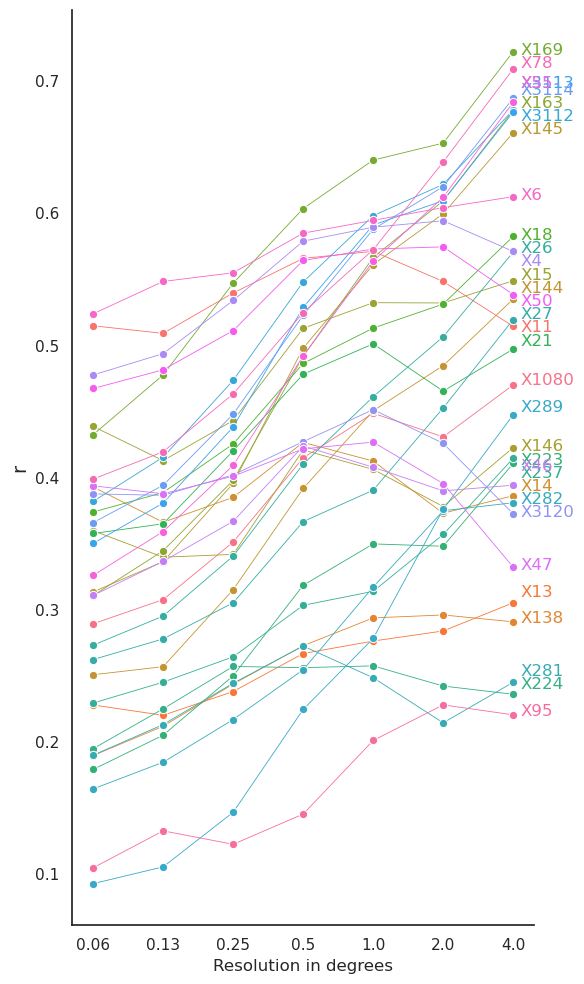

In [28]:
#### Plot 
# https://stackoverflow.com/questions/44941082/plot-multiple-columns-of-pandas-dataframe-using-seaborn

trait_names = trait

# data 
data_dropnan = r_all.dropna(axis=1, how='all')
data_melt= pd.melt(data_dropnan, ['Resolution'], value_name="r")

# change Resolution to string, so it is not interpreted as a number
data_melt = data_melt.astype({"Resolution": str}, errors='raise') 

# set plotting parameters
sns.set(rc={'figure.figsize':(6,10)}) # size
sns.set(font_scale = 2) # make font larger
sns.set_theme(style="white") # plain white plot, no grids

# initiate plot
fig, ax = plt.subplots()

# plot all lines into one plot

sns.lineplot(x='Resolution', 
            y='r', 
            hue='variable', 
            data=data_melt,
            ax=ax,
            marker='o',
            linewidth=0.6,
            legend=None)

label_pos=[]

# Add the text--for each line, find the end, annotate it with a label
# https://lost-stats.github.io/Presentation/Figures/line_graph_with_labels_at_the_beginning_or_end.html

for line, variable in zip(ax.lines, trait_names):
    y = line.get_ydata()[0]
    x = line.get_xdata()[0]
    if not np.isfinite(y):
        y=next(reversed(line.get_ydata()[~line.get_ydata().mask]),float("nan"))
    if not np.isfinite(y) or not np.isfinite(x):
        continue 
    x=round(x)
    y=round(y,2)
    xy=(x-0.1, y)
    if xy in label_pos:
        xy=(x-0.1, y-0.01)
    if xy in label_pos:
        xy=(x-0.1, y+0.015)
    if variable=="Seed Mass":
        xy=(x-0.1, y-0.02)
    if variable=="Leaf Area":
        xy=(x-0.1, y+0.005)
    label_pos.append(xy)
    text = ax.annotate(variable,
                       xy=(xy),
                       xytext=(0, 0),
                       color=line.get_color(),
                       xycoords=(ax.get_xaxis_transform(),
                                 ax.get_yaxis_transform()),
                       textcoords="offset points")
    text_width = (text.get_window_extent(
    fig.canvas.get_renderer()).transformed(ax.transData.inverted()).width)

# Format the date axis to be prettier.
sns.despine()
plt.xlabel("Resolution in degrees",  fontsize = 12)
plt.ylabel("r",  fontsize = 14) 

ax.invert_xaxis()

plt.tight_layout()

# save figure as pdf


## Determine slope of the correlation

In [29]:
%load_ext rpy2.ipython

In [53]:
%%R

library(smatr)

iNat <- read.csv("/net/scratch/swolf/grid_means_GBIFhex9_sPlot_TRYgapfilled0.5_deg.csv")

traits <- unique(iNat$Trait)

test <- data.frame()

for (t in 1:length(traits)){
      sub <- iNat[iNat$Trait == traits[[t]],]
      results <- sma(TraitValue_GBIF~TraitValue_sPlot, data=sub, slope.test=1, elev.test=0)
      coef <- data.frame(results$coef)
      ci <- data.frame(traits[[t]], coef$coef.SMA.[1], coef$coef.SMA.[2], coef$lower.limit[2], coef$upper.limit[2], results$slopetest[[1]]$p)
      test <- rbind(test,ci)}

write.csv(test, "/net/scratch/swolf/sma_stats_gapfilledTRY_GBIF.csv")


In [54]:
slopes = pd.read_csv( "/net/scratch/swolf/sma_stats_gapfilledTRY_GBIF.csv")

In [55]:
slopes.set_index(slopes["traits..t.."], inplace=True)

In [56]:
slopes.drop(["Unnamed: 0", "traits..t.."], axis=1, inplace=True)

In [57]:
slopes = slopes.transpose()


In [58]:
slopes.index = list(["intercept", "slope", "ci_lower", "ci_upper", "p"])


In [59]:
slopes

traits..t..     X1080       X11       X13      X138       X14      X144  \
intercept    1.561490  0.799960  2.199102  1.626254  1.029750  1.055145   
slope        0.814134  0.771611  0.638473  0.747841  0.697005  0.736068   
ci_lower     0.794199  0.754551  0.621912  0.728480  0.680068  0.717802   
ci_upper     0.834568  0.789057  0.655475  0.767717  0.714364  0.754799   
p            0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

traits..t..      X145      X146       X15      X163  ...     X3114     X3120  \
intercept    0.406187  0.738330  0.228705 -0.015964  ...  1.883064  0.577411   
slope        0.740719  0.751223  0.748681  0.768262  ...  0.762791  0.739881   
ci_lower     0.723210  0.732948  0.731356  0.750021  ...  0.745003  0.721856   
ci_upper     0.758653  0.769953  0.766418  0.786948  ...  0.781004  0.758356   
p            0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   

traits..t..        X4       X46       X47       X50       X55        X6  \
intercept    0.159057 -0.355154  0.036779  0.017680  1.164369 -0.185828   
slope        0.648374  0.758597  0.717335  0.810033  0.755083  0.758831   
ci_lower     0.634243  0.739989  0.699806  0.792088  0.737192  0.742739   
ci_upper     0.662820  0.777674  0.735303  0.828384  0.773408  0.775273   
p            0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

traits..t..       X78        X95  
intercept    0.399173  32.289034  
slope        0.707060   0.640924  
ci_lower     0.690894   0.623870  
ci_upper     0.723604   0.658443  
p            0.000000   0.000000  

[5 rows x 33 columns]

## Plot correlation plots for all traits at 0.5 degree resolution

We want to look at the scatterplots a bit closer now. The previous plot shows that we have a high correlation for a number of traits at a resolution of 2 degrees, so we choose this resolution in the following, more detailed analyses.

### Calculate axes ranges

In [60]:
# calculate max-min ranges

def min__max_ranges(df, col_1, col_2, variable_col, variables):

    range_all =[]

    for i in variables:
        df_sub = df[df[variable_col]==i]
        df_sub = df_sub.dropna(subset = [col_1, col_2])
    
        xmin = df_sub[col_1].quantile(0.01)
        xmax = df_sub[col_1].quantile(0.99)
    
        ymin = df_sub[col_2].quantile(0.01)
        ymax = df_sub[col_2].quantile(0.99)
    
    
        if xmin>ymin:
            if not np.isfinite(ymin):
                pass
            else:
                xmin = ymin
        else:
            pass
    
        if xmax<ymax:
            xmax=ymax
        else:
            pass
        
        range_sub = [xmin, xmax]
    
        range_all.append(range_sub)
        
    ranges  = pd.DataFrame()
    ranges['variable'] = variables
    ranges['min'] = [i[0] for i in range_all]
    ranges['max'] = [i[1] for i in range_all]
    ranges = ranges.set_index('variable')

    return ranges

We claculate data ranges for all traits, so that we can plot symmetrical scatterplots:


In [61]:
d= 0.5
filename="/net/scratch/swolf/grid_means_GBIFhex9_sPlot_TRYgapfilled0.5_deg.csv"
raster_means = pd.read_csv(filename)

ranges = min__max_ranges(raster_means, 'TraitValue_sPlot', 'TraitValue_GBIF', 
                         variable_col='Trait', variables=trait)


In [62]:
ranges

min        max
variable                      
X1080      6.934178   9.526540
X11        1.592270   3.454472
X13        6.009898   6.217972
X138       2.954693   8.832650
X14        2.357519   3.412732
X144       2.289339   4.935238
X145      -1.860731   1.659688
X146       2.738589   3.786079
X15       -0.442017   0.990104
X163      -4.328240   0.257646
X169       2.624956   5.538252
X18       -1.843944   2.786823
X21       -5.634687  -1.356739
X223       2.935744   4.068886
X224       0.377751   2.583521
X237       0.398283   2.437179
X26       -1.837306   4.755415
X27        0.147186   2.133143
X281       2.826443   4.531093
X282       5.529975   6.524775
X289       6.334390   7.103156
X3112      3.715100   8.585034
X3113      3.589858   8.366208
X3114      3.806579   8.677264
X3120      0.499506   1.992255
X4         0.300900   0.779397
X46       -1.936952  -0.731457
X47        0.167652   0.471806
X50       -0.117932   1.261445
X55        1.219404   6.117651
X6        -2.099695   1.077728
X78       -3.350960   4.496092
X95       74.764322  97.069833

In [63]:
ranges["min_ex"] = np.exp(ranges["min"])

In [64]:
ranges["max_ex"] = np.exp(ranges["max"])

In [65]:
ranges

min        max        min_ex        max_ex
variable                                                  
X1080      6.934178   9.526540  1.026775e+03  1.371904e+04
X11        1.592270   3.454472  4.914891e+00  3.164157e+01
X13        6.009898   6.217972  4.074418e+02  5.016848e+02
X138       2.954693   8.832650  1.919583e+01  6.854429e+03
X14        2.357519   3.412732  1.056471e+01  3.034805e+01
X144       2.289339   4.935238  9.868410e+00  1.391063e+02
X145      -1.860731   1.659688  1.555589e-01  5.257669e+00
X146       2.738589   3.786079  1.546515e+01  4.408320e+01
X15       -0.442017   0.990104  6.427389e-01  2.691514e+00
X163      -4.328240   0.257646  1.319074e-02  1.293880e+00
X169       2.624956   5.538252  1.380397e+01  2.542333e+02
X18       -1.843944   2.786823  1.581922e-01  1.622938e+01
X21       -5.634687  -1.356739  3.571795e-03  2.574990e-01
X223       2.935744   4.068886  1.883552e+01  5.849178e+01
X224       0.377751   2.583521  1.459000e+00  1.324369e+01
X237       0.398283   2.437179  1.489266e+00  1.144072e+01
X26       -1.837306   4.755415  1.592458e-01  1.162119e+02
X27        0.147186   2.133143  1.158569e+00  8.441353e+00
X281       2.826443   4.531093  1.688528e+01  9.286004e+01
X282       5.529975   6.524775  2.521376e+02  6.818264e+02
X289       6.334390   7.103156  5.636257e+02  1.215799e+03
X3112      3.715100   8.585034  4.106269e+01  5.350975e+03
X3113      3.589858   8.366208  3.622894e+01  4.299302e+03
X3114      3.806579   8.677264  4.499622e+01  5.867969e+03
X3120      0.499506   1.992255  1.647907e+00  7.332051e+00
X4         0.300900   0.779397  1.351074e+00  2.180157e+00
X46       -1.936952  -0.731457  1.441426e-01  4.812073e-01
X47        0.167652   0.471806  1.182526e+00  1.602887e+00
X50       -0.117932   1.261445  8.887561e-01  3.530518e+00
X55        1.219404   6.117651  3.385169e+00  4.537974e+02
X6        -2.099695   1.077728  1.224938e-01  2.937995e+00
X78       -3.350960   4.496092  3.505068e-02  8.966601e+01
X95       74.764322  97.069833  2.949392e+32  1.435135e+42

Now we can plot a scatter plot for each trait in one large panel:

In [66]:
def plot_scatterplots(df, x, y, col, variables, labels, label_x, label_y, col_wrap):
    sns.set_theme(style="white", font_scale=1.5)
    
    # The relplot function can plot multiple variable in on large figure
    g = sns.relplot(
        data=df,
        x=x, y=y,
        col=col, 
        kind="scatter", 
        col_wrap=col_wrap, 
        linewidth=0,
        alpha=0.5,
        color="midnightblue",
        palette='crest',
        facet_kws={'sharey': False, 'sharex': False}
    )

    plt.subplots_adjust(hspace=0.35, wspace=0.0)
    index=0
    two = "2"
    
    def one_over(x):
        x = np.exp(x).astype(float)
        return x

    

    # Iterate over each subplot to customize further
    for variables, ax in g.axes_dict.items():

        #plt.scatter(x=[ranges.loc["Leaf Area", "min"],ranges.loc["Leaf Area", "max"]], 
         #           y=[ranges.loc["Leaf Area", "min_ex"],ranges.loc["Leaf Area", "max_ex"]], color='red')
        
        # Plot the 1:1 line
        ax.axline([0, 0], [1, 1], color= "black", alpha=0.6, ls = ":")
        
        # Plot the splope
        m = slopes[str(variables)].iloc[1]
        b = slopes[str(variables)].iloc[0]
        ci = [round(slopes[str(variables)].iloc[2],2), round(slopes[str(variables)].iloc[3],2)]
        # get min and max values 
        x_1 = ranges.loc[variables, "min"]
        #x_2 = ranges.loc[variables, "max"]
        ax.axline([x_1, ((m*x_1)+b)], slope=m, color='red')
        
        
        # Add the title as an annotation within the plot
        if b < 0:
            sub_title= str(labels[index])+ "\n" + "r = " + str(round(r_all.loc[1, variables], 2)) + "\n" + "y = " + str(round(m,2))   + "x - " + str(abs(round(b,2)))#+ "\n95CI(m) = " + str(ci)
        else:
            sub_title= str(labels[index])+ "\n" + "r = " + str(round(r_all.loc[1, variables], 2) ) +  "\n" + "y = " + str(round(m,2)) +  "x + " + str(round(b,2)) #+ "\n95CI(m) = " + str(ci)
        ax.text(.05, 1, sub_title, transform=ax.transAxes)
        
        index+=1
     

        
    for variables, ax in g.axes_dict.items():
    # Set the axis ranges
        space = (ranges.loc[variables, "max"]-[ranges.loc[variables, "min"]]) * 0.2
        ax.set_xlim(ranges.loc[variables, "min"] - abs(space), ranges.loc[variables, "max"] + abs(space))
        ax.set_ylim(ranges.loc[variables, "min"] - abs(space), ranges.loc[variables, "max"] + abs(space))

    
    for variables, ax in g.axes_dict.items():
        # the function "1/x" is its own inverse
        inverse = one_over

        secax = ax.secondary_yaxis('right', functions=(one_over, inverse))
        from matplotlib.ticker import AutoMinorLocator
        secax.xaxis.set_minor_locator(AutoMinorLocator())
        secax.set_yscale('log')
        secax.spines['right'].set_color('gray')
        secax.tick_params(axis='y', colors='gray', which='both')
        secax.yaxis.label.set_color('gray')
        #secax.set_ylabel('[mm]', loc='top')
    
    # Edit some supporting aspects of the plot
    g.set_titles("")
    g.set_axis_labels(label_x, label_y)
    g.tight_layout()


### Plot scatterplots for all traits

In [47]:
!pwd

/net/home/swolf/iNaturalist/FuncDiv


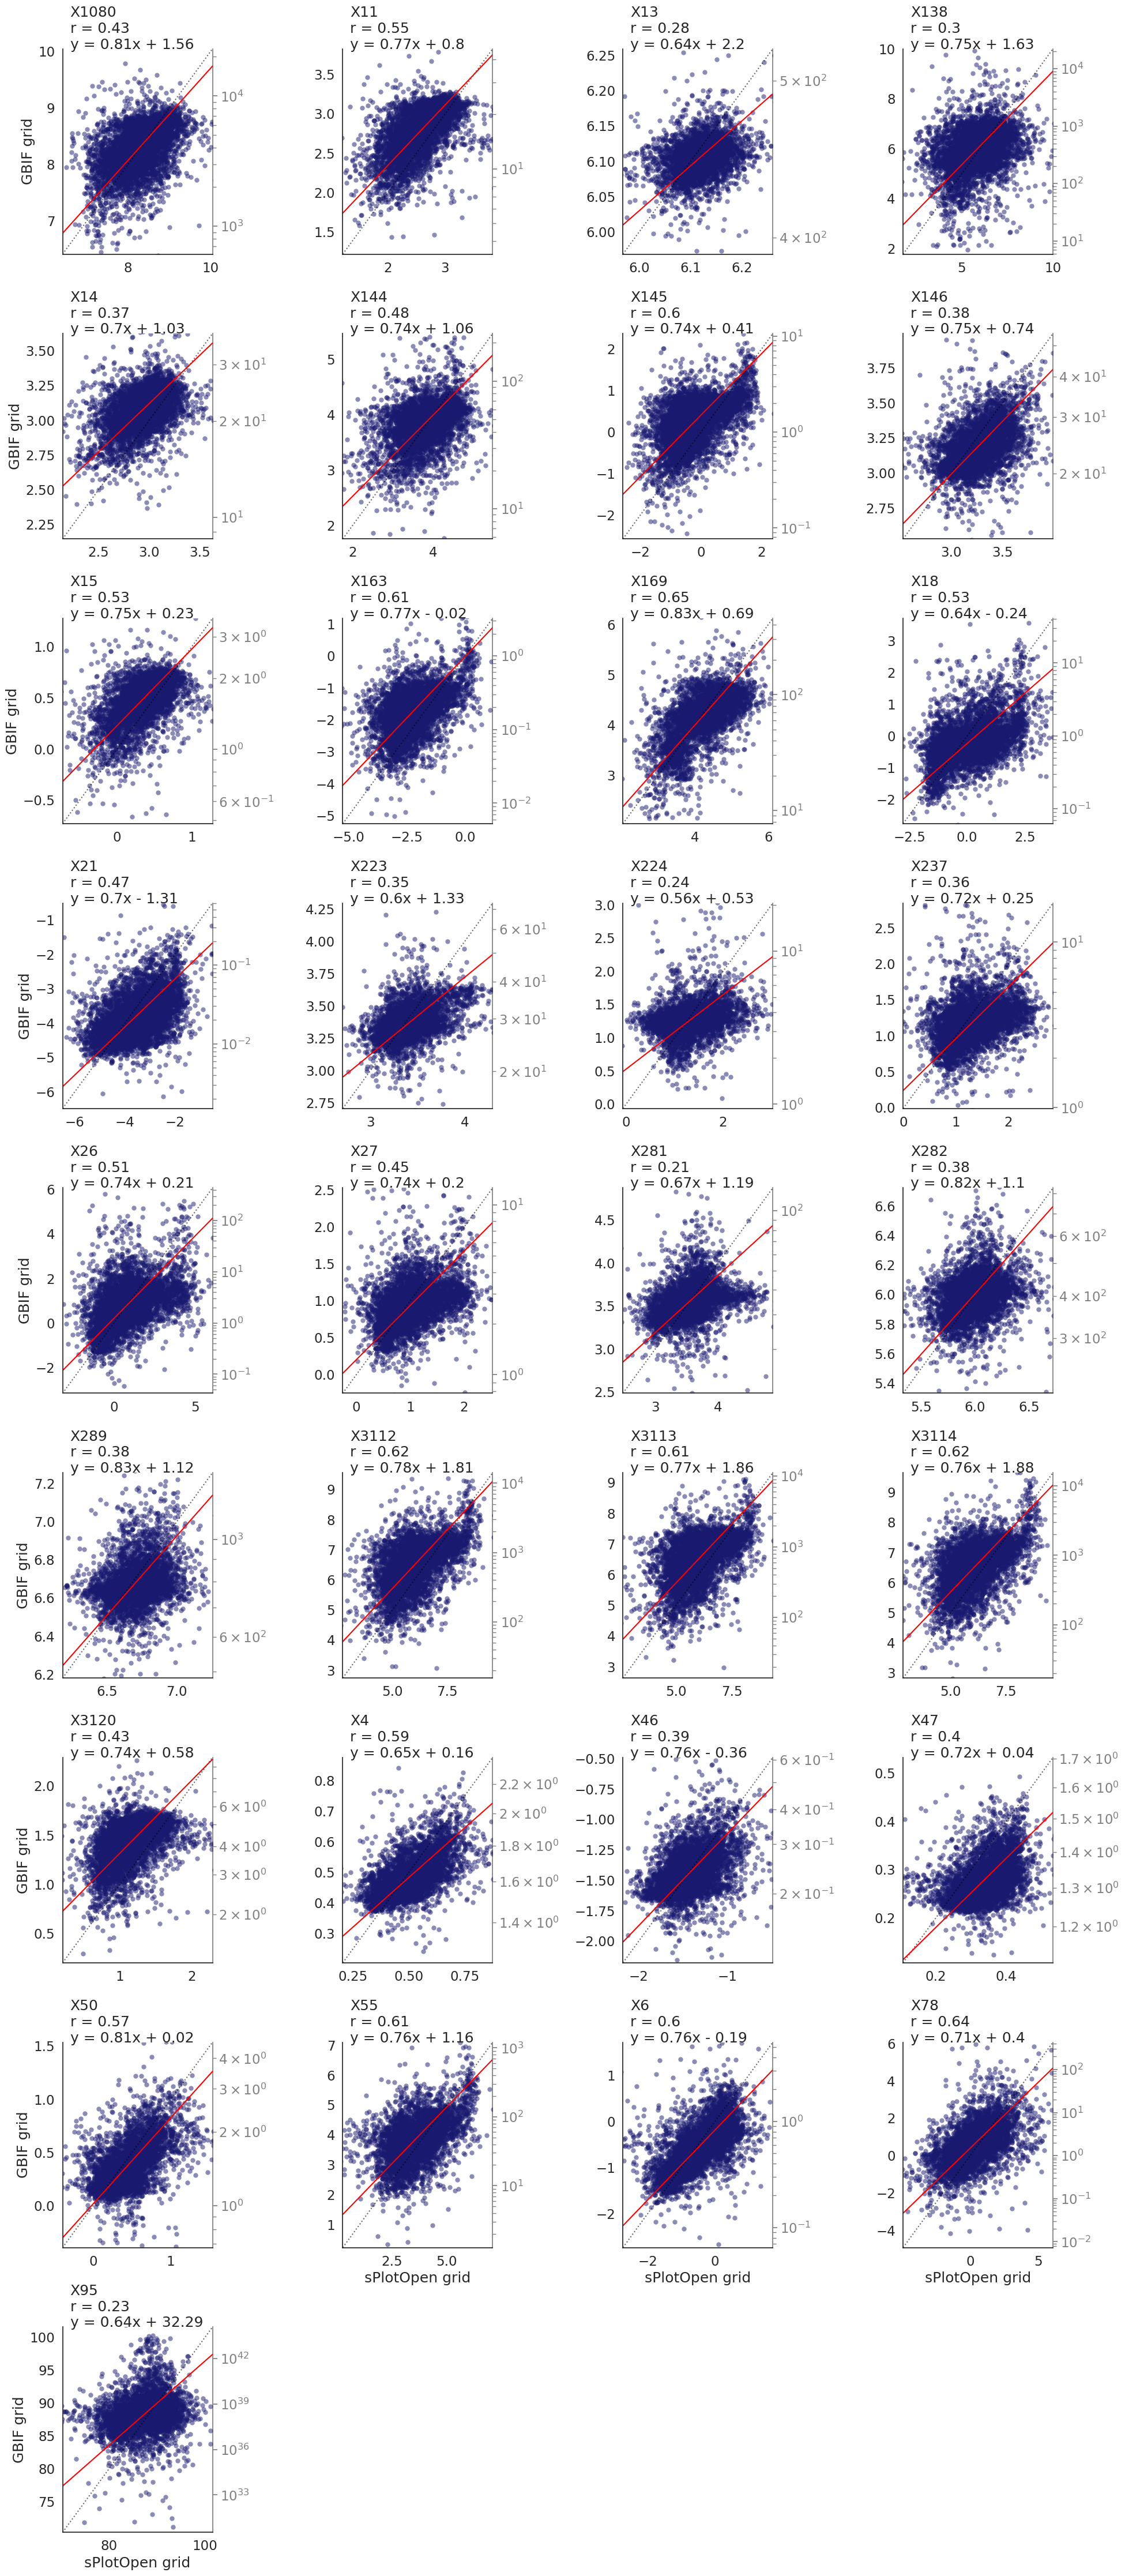

In [67]:
trait_names = trait

plot_scatterplots(raster_means, "TraitValue_sPlot", "TraitValue_GBIF", col="Trait", 
                  variables=trait, labels=trait, 
                  label_x = "sPlotOpen grid", label_y = "GBIF grid",
                 col_wrap=4)

# Save figure
plt.savefig('./Figures/corr_plots_all_r_GBIF_TRYgapfilled_05deg.pdf', bbox_inches='tight')